# Solana (SOL) Cryptocurrency Model Building

Use this as a testing notebook to ensure that model building is being executed as expected

In [ ]:
import os
# os.chdir('../') # Run this ONCE (and then comment it out)

In [2]:
from binance.client import Client as BC 
from lstm_framework.data import * 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import datetime

In [5]:
sol_data = DataProcessor('AAPL', '2020-01-01', '2025-04-01') # Preset for stock data but don't worry
sol_data.fetch_crypto_data()

sol_data.df.head()

,Open Time,Open,High,Low,Close,Volume
0,2020-08-11,2.8500,3.5208,2.8433,3.2985,1552384.78
1,2020-08-12,3.2985,3.9289,3.0800,3.7558,1737042.95
2,2020-08-13,3.7500,4.1387,3.5003,3.7300,1685759.24
3,2020-08-14,3.7207,3.7676,3.3210,3.4099,1474161.79
4,2020-08-15,3.4181,3.7400,3.1500,3.1730,1070233.20


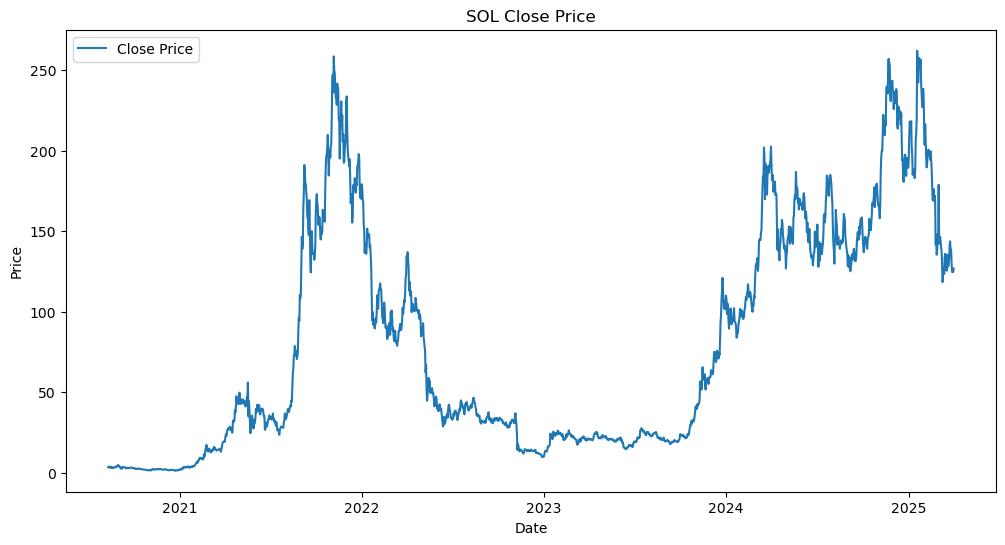

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sol_data.df['Open Time'], sol_data.df['Close'], label='Close Price')
plt.title('SOL Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


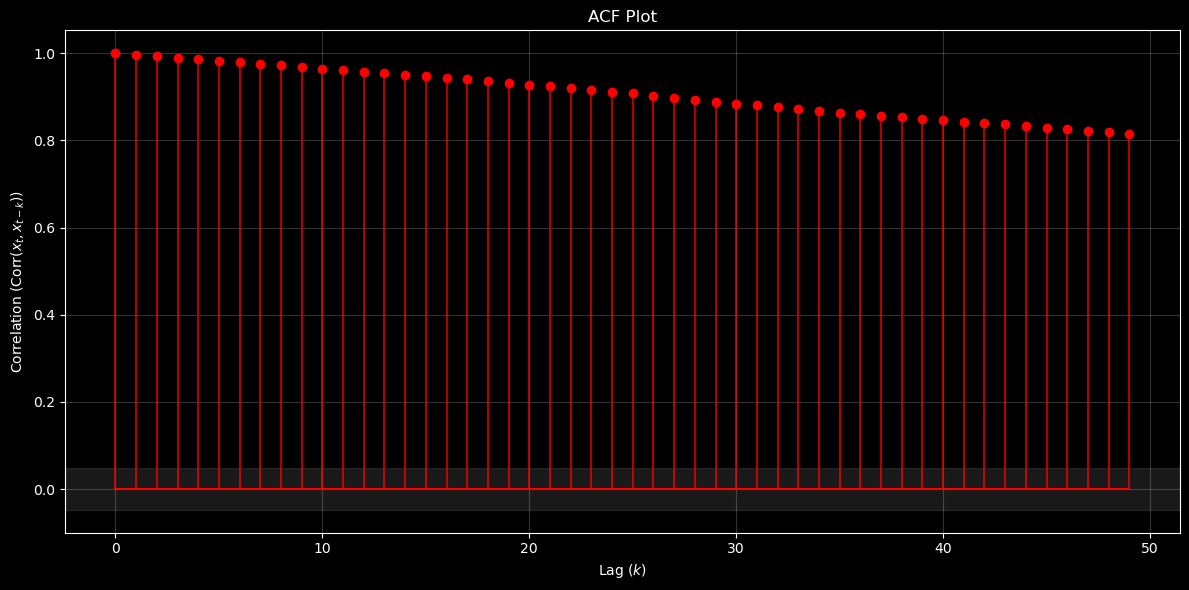

In [7]:
from lstm_framework.time_series_models import * 
sol_model = TS_Models(sol_data.df)
sol_model.acf_plot()

In [8]:
# Conversion to stationary processing through differencing operator 
sol_model.df['Close'] = sol_model.df['Close'].diff()
sol_model.df.dropna(inplace=True)

sol_model.df.head()

,Open Time,Open,High,Low,Close,Volume
1,2020-08-12,3.2985,3.9289,3.0800,0.4573,1737042.95
2,2020-08-13,3.7500,4.1387,3.5003,-0.0258,1685759.24
3,2020-08-14,3.7207,3.7676,3.3210,-0.3201,1474161.79
4,2020-08-15,3.4181,3.7400,3.1500,-0.2369,1070233.20
5,2020-08-16,3.1730,3.4907,3.1200,0.2155,668106.53


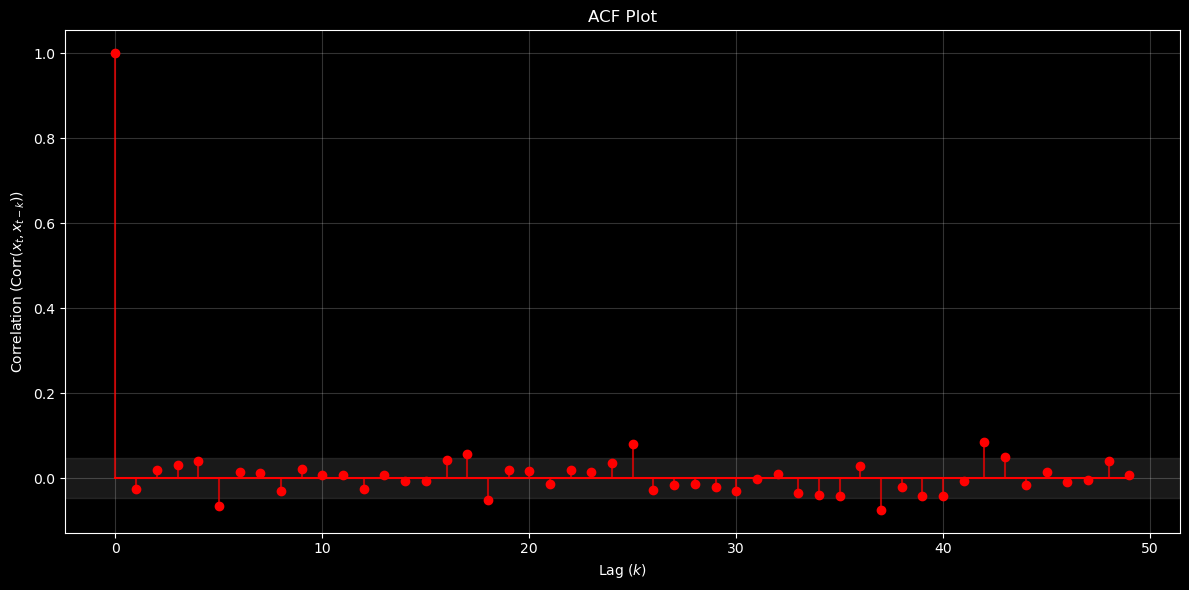

In [9]:
sol_model.acf_plot()

In [10]:
# Conversion to supervised learning problem - NOTE: Close is now returns 
sol_model.df['Open Time'] = pd.to_datetime(sol_model.df['Open Time'])

In [ ]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = pd.to_datetime(first_date_str)
  last_date  = pd.to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df